## QSS20 Final Project - Weather-based Passing Statistics in the NFL

In [62]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [2]:
pbp = nfl.import_pbp_data(range(2014,2024))

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
columns_list = list(pbp.columns)
print(columns_list)

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

### Section 1 - General

Goals:
- Filter pbp dataset to only include pass attempts
- Group by players and summarize the average epa (expected points added) and total attempts

In [4]:
pbp = pbp[pbp["pass_attempt"] == 1]

In [5]:
pbp_grouped = pbp.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa=('epa', 'mean'), sum_att=('pass_attempt', 'sum'))
pbp_filtered = pbp_grouped[pbp_grouped["sum_att"] > 500]
pd.set_option('display.max_rows', None)
pbp_filtered = pbp_filtered.sort_values(by="mean_epa", ascending=False)

In [108]:
pbp_filtered.head(20)


,team,mean_epa,sum_att
passer_player_name,,,
B.Purdy,SF,0.260180,833.0
P.Mahomes,KC,0.222529,4455.0
T.Romo,DAL,0.184863,655.0
T.Brady,TB,0.156850,6715.0
D.Brees,NO,0.155805,4176.0
A.Rodgers,NYJ,0.137633,5241.0
J.Garoppolo,LV,0.135447,2180.0
J.Love,GB,0.132817,754.0
P.Rivers,IND,0.126503,4393.0


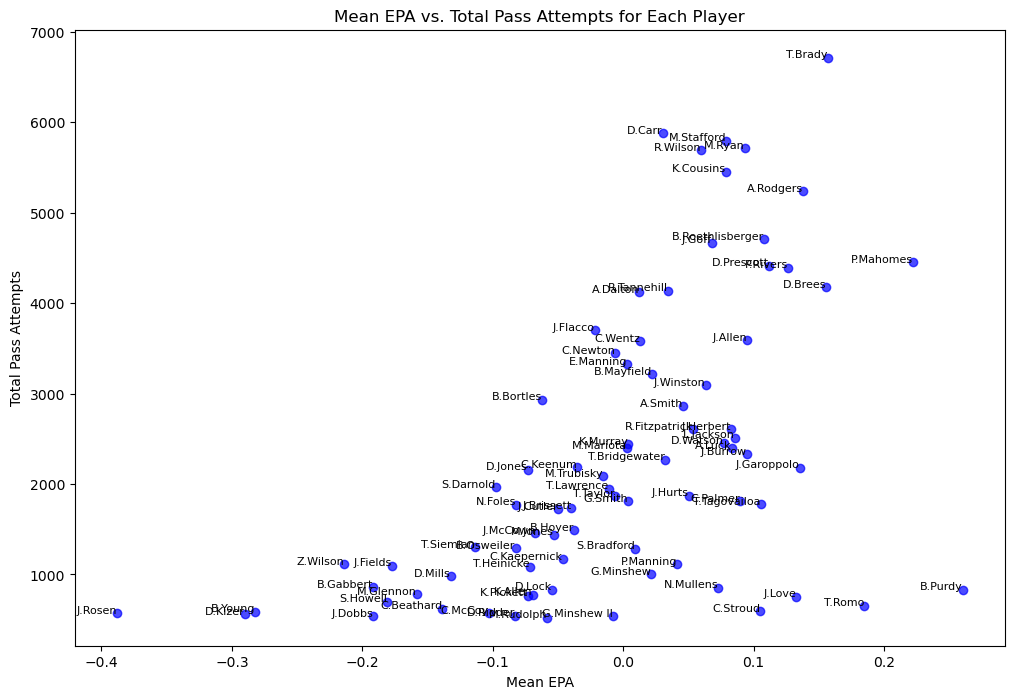

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(pbp_filtered['mean_epa'], pbp_filtered['sum_att'], color='blue', alpha=0.7)

plt.xlabel('Mean EPA')
plt.ylabel('Total Pass Attempts')
plt.title('Mean EPA vs. Total Pass Attempts for Each Player')

for player, row in pbp_filtered.iterrows():
    plt.annotate(player, (row['mean_epa'], row['sum_att']), fontsize=8, ha='right')

plt.show()


### Section 2 - Weather

In [109]:
#This is what the weather column looks like
pbp["weather"].head()

4     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
7     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
8     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
9     Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
12    Sunny Temp: 74° F, Humidity: 45%, Wind: NE 3 mph
Name: weather, dtype: object

# Create a function that extracts the weather

In [9]:
#Let us see what we are working with first
pbp['first_word_weather'] = pbp['weather'].str.split().str[0]
pbp["first_word_weather"].value_counts()

/var/folders/6q/jmrgx0xj5t7b7l152lzdznmr0000gn/T/ipykernel_78330/2493116823.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp['first_word_weather'] = pbp['weather'].str.split().str[0]


first_word_weather
Cloudy           47717
Sunny            41210
Partly           22712
Temp:            20938
Clear            16710
Mostly           14828
Rain              6961
Controlled        6077
N/A               6070
Fair              2601
Indoors           2226
Overcast          1555
Cloudy,           1430
Light             1395
Snow               852
Sunny,             737
Indoor             651
Hazy               436
Clear,             400
cloudy             305
Rainy              292
No                 250
clear              223
T:                 223
Cold               222
sunny              199
Scattered          196
Foggy              170
0%                 160
n/a                159
Party              147
SUNNY              145
partly             138
Showers            130
Thunderstorms       99
Mosly               92
Mid                 91
Outdoor             89
Dry                 87
Steady              84
Climate             83
Zero                79
sUNNY          

As we can see, a lot of synonyms. We could use AI to group them but I will just do it manually. We can also see that many entries do not have proper weather entries

In [156]:
pbp['is_sunny'] = np.where(pbp['weather'].str.contains('sunny|clear', case=False, na=False), 1, 0)
pbp['is_cloudy'] = np.where(pbp['weather'].str.contains('Cloudy | Cloudly', case=False, na=False), 1, 0)
pbp['is_percipitation'] = np.where(pbp['weather'].str.contains('Rain | Raining, | scattered | Raining | Thunderstorms | Showers | Scattered | Snow | Flurries | Scattered', case=False, na=False), 1, 0)

print(pbp[["is_sunny", "is_cloudy", "is_percipitation"]].mean())

is_sunny            0.336594
is_cloudy           0.379742
is_percipitation    0.052960
dtype: float64


In [157]:
mean_epa_sunny = pbp.loc[pbp["is_sunny"] == 1, "epa"].mean()
mean_epa_cloudy = pbp.loc[pbp["is_cloudy"] == 1, "epa"].mean()
mean_epa_rainy = pbp.loc[pbp["is_percipitation"] == 1, "epa"].mean()
print(mean_epa_sunny, mean_epa_cloudy, mean_epa_rainy)

0.030000351 0.022475053 -0.043500226


We do not have many entries, but we can clearly see the **epa goes down significantly when it is rainy.**

In [158]:
pbp_sunny = pbp[pbp["is_sunny"] == 1]
pbp_cloudy = pbp[pbp["is_cloudy"] == 1]
pbp_rainy = pbp[pbp["is_percipitation"] == 1]

In [115]:
pbp_grouped_sunny = pbp_sunny.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa_sunny=('epa', 'mean'), sum_att_sunny=('pass_attempt', 'sum'))
pbp_filtered_sunny = pbp_grouped_sunny[pbp_grouped_sunny["sum_att_sunny"] > 100]
pd.set_option('display.max_rows', None)
pbp_filtered_sunny = pbp_filtered_sunny.sort_values(by="mean_epa_sunny", ascending=False)
print(f"EPA in optimal weather: {pbp_filtered_sunny}")

EPA in optimal weather:                     team  mean_epa_sunny  sum_att_sunny
passer_player_name                                     
B.Purdy               SF        0.368618          282.0
P.Mahomes             KC        0.341232          962.0
T.Tagovailoa         MIA        0.271133          410.0
J.Winston             NO        0.265811          381.0
L.Jackson            BAL        0.252330          454.0
T.Brady               TB        0.238825         1213.0
Aa.Rodgers            GB        0.196977          143.0
J.Love                GB        0.189867          132.0
J.Garoppolo           LV        0.185440          984.0
A.Rodgers             GB        0.172214          769.0
C.Stroud             HOU        0.166537          221.0
A.Luck               IND        0.150197          828.0
J.Burrow             CIN        0.144420          873.0
R.Fitzpatrick        WAS        0.136564          539.0
J.Hurts              PHI        0.128291          345.0
C.Palmer             ARI

In [159]:
pbp_grouped_cloudy = pbp_cloudy.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa_cloudy=('epa', 'mean'), sum_att_cloudy=('pass_attempt', 'sum'))
pbp_filtered_cloudy = pbp_grouped_cloudy[pbp_grouped_cloudy["sum_att_cloudy"] > 50]
pd.set_option('display.max_rows', None)
pbp_filtered_cloudy = pbp_filtered_cloudy.sort_values(by="mean_epa_cloudy", ascending=False)
print(f"EPA in cloudy weather: {pbp_filtered_cloudy}")

EPA in cloudy weather:                    team  mean_epa_cloudy  sum_att_cloudy
passer_player_name                                      
Jos.Allen           BUF         0.357568            55.0
T.Romo              DAL         0.307713           239.0
Aa.Rodgers           GB         0.306510            69.0
J.Johnson            SF         0.247485            95.0
P.Mahomes            KC         0.234076          1207.0
C.Henne              KC         0.227590            58.0
D.Mills             HOU         0.205575           159.0
B.Purdy              SF         0.185875           302.0
M.White             MIA         0.183492            64.0
D.Brees              NO         0.177519          1780.0
N.Mullens           MIN         0.160632           286.0
A.Rodgers            GB         0.154775          1981.0
J.Herbert           LAC         0.153909           713.0
T.Brady              TB         0.143720          3246.0
M.Stafford           LA         0.125878          1569.0
B.Weeden

In [116]:
pbp_grouped_rainy = pbp_rainy.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa_rainy=('epa', 'mean'), sum_att_rainy=('pass_attempt', 'sum'))
pbp_filtered_rainy = pbp_grouped_rainy[pbp_grouped_rainy["sum_att_rainy"] > 20]
pd.set_option('display.max_rows', None)
pbp_filtered_rainy = pbp_filtered_rainy.sort_values(by="mean_epa_rainy", ascending=False)
print(f"EPA in rainy weather: {pbp_filtered_rainy}")

EPA in rainy weather:                    team  mean_epa_rainy  sum_att_rainy
passer_player_name                                    
C.Stroud            HOU        0.430816           28.0
J.Herbert           LAC        0.343959           70.0
N.Foles             PHI        0.326944           37.0
B.Purdy              SF        0.323384           77.0
J.Burrow            CIN        0.311788           38.0
D.Brees              NO        0.307457          216.0
J.Garoppolo          SF        0.292898          104.0
M.White             NYJ        0.254357           76.0
B.Hoyer             HOU        0.253465           61.0
T.Boyle             DET        0.194662           38.0
K.Murray            ARI        0.188418           23.0
M.Ryan              ATL        0.187720           76.0
L.McCown             NO        0.185661           40.0
M.Stafford           LA        0.170289          141.0
T.Brady              TB        0.166234          488.0
R.Fitzpatrick        TB        0.146743    

In [160]:
pbp_merged = pbp_filtered.merge(pbp_filtered_sunny, on=['passer_player_name', 'team'], how='left')
pbp_merged = pbp_merged.merge(pbp_filtered_cloudy, on=['passer_player_name', 'team'], how='left')
pbp_merged = pbp_merged.merge(pbp_filtered_rainy, on=['passer_player_name', 'team'], how='left')

print(pbp_merged)

                   team  mean_epa  sum_att  mean_epa_sunny  sum_att_sunny  \
passer_player_name                                                          
B.Purdy              SF  0.260180    833.0        0.368618          282.0   
P.Mahomes            KC  0.222529   4455.0        0.341232          962.0   
T.Romo              DAL  0.184863    655.0             NaN            NaN   
T.Brady              TB  0.156850   6715.0        0.238825         1213.0   
D.Brees              NO  0.155805   4176.0        0.096325         1018.0   
A.Rodgers           NYJ  0.137633   5241.0             NaN            NaN   
J.Garoppolo          LV  0.135447   2180.0        0.185440          984.0   
J.Love               GB  0.132817    754.0        0.189867          132.0   
P.Rivers            IND  0.126503   4393.0        0.070866         1716.0   
D.Prescott          DAL  0.111451   4417.0        0.041924          522.0   
B.Roethlisberger    PIT  0.108336   4707.0        0.087983         1156.0   

### Section 3 - Temperatures

Going back to the weather variable, we will take the temperature given. And we will look at games in below freezing weather vs. above freezing weather.

In [161]:
# Extract the temperature values directly before the degree symbol
pbp['temperature'] = pbp['weather'].str.extract(r'([-+]?\d+)(?=°)', expand=False)

# Convert the temperature column to numeric, handling NaN values
pbp['temperature'] = pd.to_numeric(pbp['temperature'], errors='coerce')

# Create the is_below_freezing column
pbp['is_below_freezing'] = pbp['temperature'] < 32

# Display the updated DataFrame
print(pbp.head())


    play_id          game_id old_game_id home_team away_team season_type  \
4      93.0  2014_01_BUF_CHI  2014090702       CHI       BUF         REG   
7     162.0  2014_01_BUF_CHI  2014090702       CHI       BUF         REG   
8     186.0  2014_01_BUF_CHI  2014090702       CHI       BUF         REG   
9     210.0  2014_01_BUF_CHI  2014090702       CHI       BUF         REG   
12    302.0  2014_01_BUF_CHI  2014090702       CHI       BUF         REG   

    week posteam posteam_type defteam  ... defense_coverage_type  \
4      1     BUF         away     CHI  ...                   NaN   
7      1     CHI         home     BUF  ...                   NaN   
8      1     CHI         home     BUF  ...                   NaN   
9      1     CHI         home     BUF  ...                   NaN   
12     1     BUF         away     CHI  ...                   NaN   

    first_word_weather is_sunny  is_cloudy  is_percipitation  temperature  \
4                Sunny        1          0               

In [162]:
pbp['temperature'] = pbp['weather'].str.extract(r'([-+]?\d+)(?=°)', expand=False)
pbp["temperature"] = pd.to_numeric(pbp['temperature'], errors='coerce')
pbp["is_cold"] = np.where(pbp["temperature"] <= 32, 1, 0)
print(pbp["is_cold"].mean())
pbp_cold = pbp[pbp["is_cold"] == 1]
mean_epa_cold = pbp.loc[pbp["is_cold"] == 1, "epa"].mean()
print(f"EPA in cold weather: {mean_epa_cold}")

0.04917039132298807
EPA in cold weather: -0.016088498756289482


As we can see here, the EPA decreases in cold weather just like it does in the rain. This makes sense with our original hypotheses.

In [163]:
pbp_grouped_cold = pbp_cold.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa_cold=('epa', 'mean'), sum_att_cold=('pass_attempt', 'sum'))
pbp_filtered_cold = pbp_grouped_cold[pbp_grouped_cold["sum_att_cold"] > 50]
pd.set_option('display.max_rows', None)
pbp_filtered_cold = pbp_filtered_cold.sort_values(by="mean_epa_cold", ascending=False)
print(f"EPA in cold weather: {pbp_filtered_cold}")

EPA in cold weather:                    team  mean_epa_cold  sum_att_cold
passer_player_name                                  
J.Love               GB       0.390115          75.0
A.Rodgers            GB       0.221686         812.0
L.Jackson           BAL       0.207006          51.0
T.Brady              TB       0.173609         623.0
P.Mahomes            KC       0.161765         608.0
J.Burrow            CIN       0.157451         177.0
D.Prescott          DAL       0.152289         124.0
R.Tannehill         TEN       0.133957          90.0
T.Taylor            BUF       0.127370         124.0
M.Stafford           LA       0.094063         156.0
M.Ryan              IND       0.086572         225.0
J.Allen             BUF       0.084048         375.0
M.Jones              NE       0.026854         121.0
P.Rivers            LAC       0.021603          96.0
B.Roethlisberger    PIT       0.013758         279.0
B.Osweiler          DEN       0.011264         217.0
K.Pickett           PIT  

### Section 4 - Wind

In [164]:
pbp['wind_speed'] = pbp['weather'].str.extract(r'(\d+)\s*mph')[0].astype(float)
pbp["wind_speed"] = pd.to_numeric(pbp['wind_speed'], errors='coerce')
pbp["wind_speed"].value_counts()
pbp["is_windy"] = np.where(pbp["wind_speed"] >= 15, 1, 0)
print(pbp["is_windy"].mean())
pbp_windy = pbp[pbp["is_windy"] == 1]
mean_epa_windy = pbp.loc[pbp["is_windy"] == 1, "epa"].mean()
print(f"EPA in windy weather: {mean_epa_windy}")

0.08998802525045953
EPA in windy weather: -0.018401216715574265


EPA also decreases in wind

In [165]:
pbp_grouped_windy = pbp_cold.groupby("passer_player_name").agg(team=('posteam', 'last'), mean_epa_wind=('epa', 'mean'), sum_att_wind=('pass_attempt', 'sum'))
pbp_filtered_windy = pbp_grouped_windy[pbp_grouped_windy["sum_att_wind"] > 50]
pd.set_option('display.max_rows', None)
pbp_filtered_windy = pbp_filtered_windy.sort_values(by="mean_epa_wind", ascending=False)
print(f"EPA in windy weather: {pbp_filtered_windy}")

EPA in windy weather:                    team  mean_epa_wind  sum_att_wind
passer_player_name                                  
J.Love               GB       0.390115          75.0
A.Rodgers            GB       0.221686         812.0
L.Jackson           BAL       0.207006          51.0
T.Brady              TB       0.173609         623.0
P.Mahomes            KC       0.161765         608.0
J.Burrow            CIN       0.157451         177.0
D.Prescott          DAL       0.152289         124.0
R.Tannehill         TEN       0.133957          90.0
T.Taylor            BUF       0.127370         124.0
M.Stafford           LA       0.094063         156.0
M.Ryan              IND       0.086572         225.0
J.Allen             BUF       0.084048         375.0
M.Jones              NE       0.026854         121.0
P.Rivers            LAC       0.021603          96.0
B.Roethlisberger    PIT       0.013758         279.0
B.Osweiler          DEN       0.011264         217.0
K.Pickett           PIT 

### Section 5 - Regression + XGBoost

In [166]:

import statsmodels.api as sm

pbp_games = pbp.groupby(["game_id", "passer_player_name"]).agg(sum_epa=("epa", "sum"), att = ("pass_attempt", "sum"), yards = ("passing_yards", "sum"), mean_temp=("temperature", "mean"), is_sunny=("is_sunny","max"), is_cloudy=("is_cloudy","max"), is_rainy = ("is_percipitation", "max"), mean_wind = ("wind_speed", "mean"), is_cold = ("is_cold", "max"), is_windy = ("is_windy", "max")).reset_index()
pbp.columns
pbp_games.head(30)
pbp_games = pbp_games.dropna(subset=['sum_epa', 'yards', 'is_sunny', 'mean_temp', 'mean_wind', 'is_cloudy', 'is_rainy', 'is_cold', 'is_windy'])

y1 = pbp_games['sum_epa']
X1 = pbp_games[['is_rainy', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X1 = sm.add_constant(X1)

# Performing OLS regression
model1 = sm.OLS(y1, X1).fit()

# Displaying the regression results
print(model1.summary())

y2 = pbp_games['sum_epa']
X2 = pbp_games[['is_sunny', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X2 = sm.add_constant(X2)

# Performing OLS regression
model2 = sm.OLS(y2, X2).fit()

# Displaying the regression results
print(model2.summary())

y3 = pbp_games['sum_epa']
X3 = pbp_games[['is_cloudy', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X3 = sm.add_constant(X3)

# Performing OLS regression
model3 = sm.OLS(y3, X3).fit()

# Displaying the regression results
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                sum_epa   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     12.48
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           3.93e-08
Time:                        11:17:32   Log-Likelihood:                -21464.
No. Observations:                5790   AIC:                         4.294e+04
Df Residuals:                    5786   BIC:                         4.296e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1482      0.543     -0.273      0.7

Cloudy and Sunny does not have an effect on weather. **But rain, wind speed, and temperature all do.**

In [167]:

import statsmodels.api as sm

pbp_games = pbp.groupby(["game_id", "passer_player_name"]).agg(sum_epa=("epa", "sum"), att = ("pass_attempt", "sum"), yards = ("passing_yards", "sum"), mean_temp=("temperature", "mean"), is_sunny=("is_sunny","max"), is_cloudy=("is_cloudy","max"), is_rainy = ("is_percipitation", "max"), mean_wind = ("wind_speed", "mean"), is_cold = ("is_cold", "max"), is_windy = ("is_windy", "max")).reset_index()
pbp.columns
pbp_games.head(30)
pbp_games = pbp_games.dropna(subset=['sum_epa', 'yards', 'is_sunny', 'mean_temp', 'mean_wind', 'is_cloudy', 'is_rainy', 'is_cold', 'is_windy'])

y4 = pbp_games['yards']
X4 = pbp_games[['is_rainy', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X4 = sm.add_constant(X4)

# Performing OLS regression
model4 = sm.OLS(y4, X4).fit()

# Displaying the regression results
print(model4.summary())

y5 = pbp_games['yards']
X5 = pbp_games[['is_sunny', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X5 = sm.add_constant(X5)

# Performing OLS regression
model5 = sm.OLS(y5, X5).fit()

# Displaying the regression results
print(model5.summary())

y6 = pbp_games['yards']
X6 = pbp_games[['is_cloudy', 'mean_wind', "mean_temp"]]

# Adding a constant to the predictors for the intercept
X6 = sm.add_constant(X6)

# Performing OLS regression
model6= sm.OLS(y6, X6).fit()

# Displaying the regression results
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                  yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     13.02
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.80e-08
Time:                        11:17:35   Log-Likelihood:                -35364.
No. Observations:                5790   AIC:                         7.074e+04
Df Residuals:                    5786   BIC:                         7.076e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.4760      5.995     30.772      0.0

In [168]:
from sklearn.model_selection import train_test_split
pbp_games = pbp_games[pbp_games["att"] >= 10]
train_gbg1, test_gbg1 = train_test_split(pbp_games, test_size=0.2, random_state=42)
print("Training Set Shape:", train_gbg1.shape)
print("Test Set Shape:", test_gbg1.shape)
train_gbg1.head()

Training Set Shape: (3930, 12)
Test Set Shape: (983, 12)


,game_id,passer_player_name,sum_epa,att,yards,mean_temp,is_sunny,is_cloudy,is_rainy,mean_wind,is_cold,is_windy
4712,2021_06_GB_CHI,Aa.Rodgers,6.792426,26.0,195.0,62.0,1,0,0,5.0,0,0
586,2014_17_CIN_PIT,A.Dalton,-4.906590,41.0,244.0,37.0,0,1,0,5.0,0,0
1445,2016_06_DEN_SD,P.Rivers,2.645859,31.0,178.0,70.0,0,0,0,9.0,0,0
5792,2022_16_HOU_TEN,M.Willis,-17.224499,27.0,99.0,20.0,1,0,0,10.0,1,0
4489,2020_18_IND_BUF,P.Rivers,14.806331,47.0,309.0,34.0,1,0,0,6.0,0,0


In [169]:
import xgboost as xgb
train_gbg = train_gbg1.drop(train_gbg1.columns[[3, 4]], axis=1)
test_gbg = test_gbg1.drop(test_gbg1.columns[[3, 4]], axis=1)

train_desc = train_gbg.iloc[:, 0:2]

train_label = train_gbg["sum_epa"]

train_features = train_gbg.iloc[:, 3:]


test_desc = test_gbg.iloc[:, 0:2]

test_label = test_gbg["sum_epa"]

test_features = test_gbg.iloc[:, 3:]


In [170]:
total_na = test_gbg['sum_epa'].isna().sum()
print("Total NA values in column:", total_na)


Total NA values in column: 0


In [171]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Prepare DMatrix for training and testing
dtrain = xgb.DMatrix(data=train_features, label=train_label)
dtest = xgb.DMatrix(data=test_features, label=test_label)

# Model parameters
param = {
    'max_depth': 3,
    'eta': 0.14,
    'objective': 'reg:squarederror',  # Regression objective
    'nthread': 4,
    'eval_metric': 'rmse'             # Use RMSE for regression
}

# Training parameters
num_boost_round = 500
early_stopping_rounds = 1
evallist = [(dtest, 'eval'), (dtrain, 'train')]

# Train the model
model = xgb.train(param, dtrain, num_boost_round, evals=evallist, early_stopping_rounds=early_stopping_rounds)
model.save_model('0001.model')

# Make predictions for test and train data
ypred_test = model.predict(dtest)
ypred_train = model.predict(dtrain)

# Create DataFrames for predictions and labels
pred_df_test = pd.DataFrame(ypred_test, columns=['predicted_values'])
pred_df_train = pd.DataFrame(ypred_train, columns=['predicted_values'])
test_label_df = test_label.reset_index(drop=True).to_frame(name="sum_epa")
train_label_df = train_label.reset_index(drop=True).to_frame(name="sum_epa")

# Concatenate the predictions with the original test features and labels
test_with_predictions = pd.concat([test_gbg.reset_index(drop=True), pred_df_test], axis=1)
train_with_predictions = pd.concat([train_gbg.reset_index(drop=True), pred_df_train], axis=1)

# Display the resulting DataFrame for test set
print("Test Data with Predictions:")
print(train_with_predictions.head())


[0]	eval-rmse:10.69672	train-rmse:10.61197
[1]	eval-rmse:10.69392	train-rmse:10.59692
[2]	eval-rmse:10.69094	train-rmse:10.58295
[3]	eval-rmse:10.68699	train-rmse:10.57242
[4]	eval-rmse:10.68847	train-rmse:10.56281
[5]	eval-rmse:10.68364	train-rmse:10.55472
[6]	eval-rmse:10.68037	train-rmse:10.54657
[7]	eval-rmse:10.68405	train-rmse:10.53835
[8]	eval-rmse:10.67718	train-rmse:10.53246
[9]	eval-rmse:10.67934	train-rmse:10.52742
[10]	eval-rmse:10.67562	train-rmse:10.52239
[11]	eval-rmse:10.66835	train-rmse:10.51511
[12]	eval-rmse:10.66255	train-rmse:10.51138
[13]	eval-rmse:10.66906	train-rmse:10.50463
[14]	eval-rmse:10.66481	train-rmse:10.50175
[15]	eval-rmse:10.66475	train-rmse:10.49784
[16]	eval-rmse:10.66881	train-rmse:10.49212
[17]	eval-rmse:10.67100	train-rmse:10.48615
[18]	eval-rmse:10.67056	train-rmse:10.48391
[19]	eval-rmse:10.67352	train-rmse:10.47875
[20]	eval-rmse:10.67766	train-rmse:10.47310
[21]	eval-rmse:10.67829	train-rmse:10.46897
[22]	eval-rmse:10.67812	train-rmse:10.4644

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:18:06] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [172]:
# Combine train_with_predictions and test_with_predictions
predictions = pd.concat([train_with_predictions, test_with_predictions], axis=0)

# Display the combined DataFrame
print("Combined DataFrame (Train + Test):")
print(predictions.head())

Combined DataFrame (Train + Test):
           game_id passer_player_name    sum_epa  mean_temp  is_sunny  \
0   2021_06_GB_CHI         Aa.Rodgers   6.792426       62.0         1   
1  2014_17_CIN_PIT           A.Dalton  -4.906590       37.0         0   
2   2016_06_DEN_SD           P.Rivers   2.645859       70.0         0   
3  2022_16_HOU_TEN           M.Willis -17.224499       20.0         1   
4  2020_18_IND_BUF           P.Rivers  14.806331       34.0         1   

   is_cloudy  is_rainy  mean_wind  is_cold  is_windy  predicted_values  
0          0         0        5.0        0         0          2.154215  
1          1         0        5.0        0         0          1.752046  
2          0         0        9.0        0         0         -0.369585  
3          0         0       10.0        1         0          3.898484  
4          0         0        6.0        0         0          3.233389  


### Testing for error

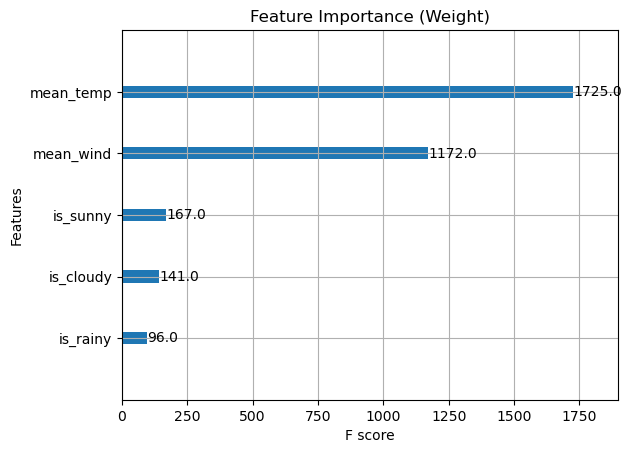

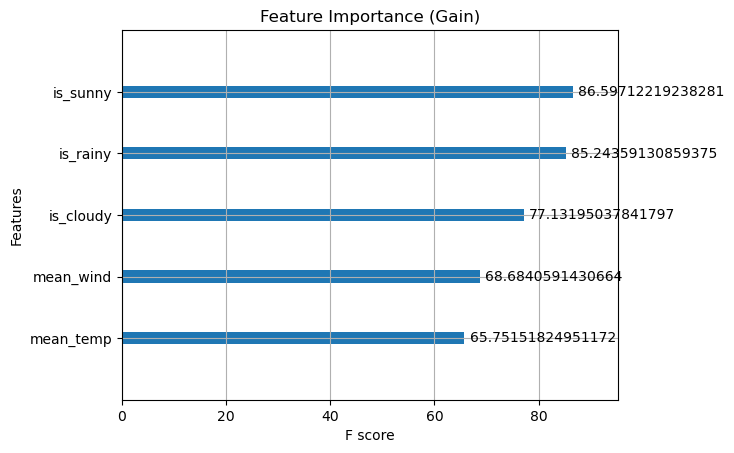

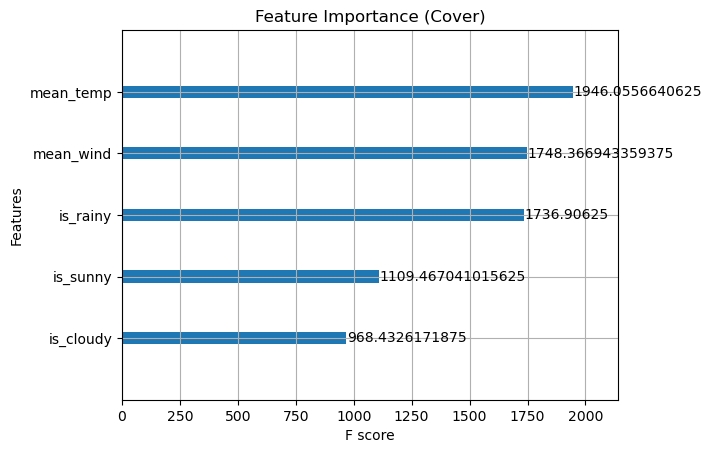

In [173]:

# Plot feature importance based on gain, weight, and cover
importance_types = ['weight', 'gain', 'cover']
for imp_type in importance_types:
    xgb.plot_importance(model, importance_type=imp_type, max_num_features=10)
    plt.title(f'Feature Importance ({imp_type.capitalize()})')
    plt.show()


<Figure size 6000x4500 with 0 Axes>

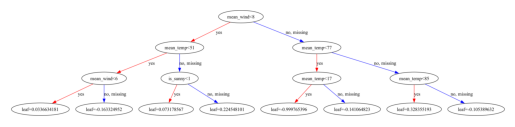

In [174]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Set up the plot size and quality
plt.figure(figsize=(20, 15), dpi=300)  # Increase figure size and DPI for better quality

# Plot the first tree from the XGBoost model
plot_tree(model, num_trees=0)

# Customize font size for better readability
plt.xticks(fontsize=12)  # Adjust x-axis labels font size
plt.yticks(fontsize=12)  # Adjust y-axis labels font size

# Display the plot
plt.show()


K-fold cross validation:

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        10.609732        0.023335       10.630723       0.091860
1        10.590544        0.024759       10.626562       0.095714
2        10.576884        0.025091       10.622937       0.093339
3        10.563027        0.025346       10.622774       0.096496
4        10.552044        0.025368       10.618095       0.097012
5        10.539317        0.026871       10.617913       0.097047
6        10.529580        0.026604       10.617891       0.097674
7        10.521104        0.026987       10.616816       0.098809


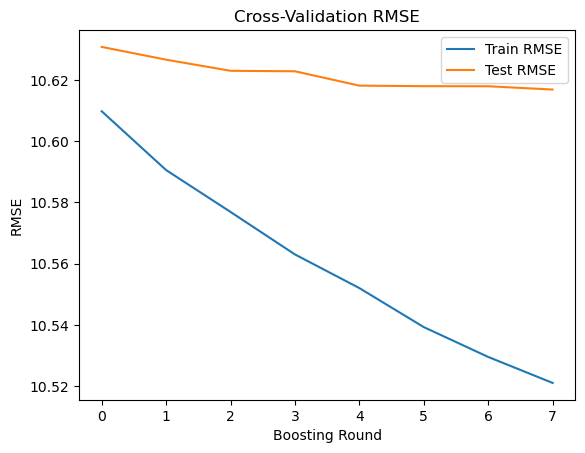

In [175]:
dtrain = xgb.DMatrix(data=train_features, label=train_label)
params = {
    'max_depth': 3,
    'eta': 0.14,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

cv_results = xgb.cv(params, dtrain, num_boost_round=500, nfold=5, early_stopping_rounds=10, seed=42)
print(cv_results)

plt.plot(cv_results['train-rmse-mean'], label='Train RMSE')
plt.plot(cv_results['test-rmse-mean'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.title('Cross-Validation RMSE')
plt.show()


Residual analysis

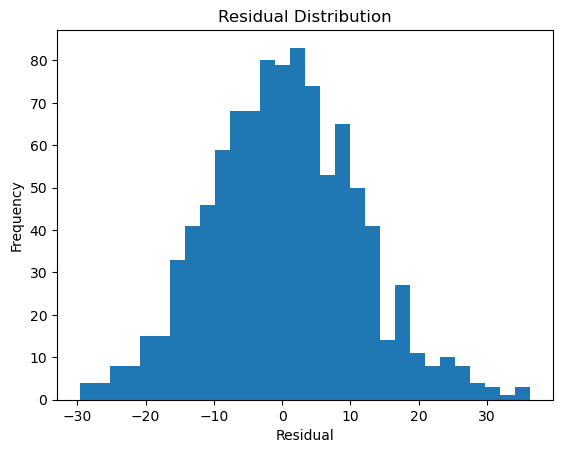

In [176]:
residuals = test_with_predictions['predicted_values'] - test_with_predictions['sum_epa']
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()


Bias analysis

In [177]:
mean_residual = residuals.mean()
print(f"Mean Residual (Bias Estimate): {mean_residual}")


Mean Residual (Bias Estimate): 0.3393363952636719


Overall model evaluation (MAE, MSE, RMSE)

In [178]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_with_predictions['sum_epa'], test_with_predictions['predicted_values'])
mse = mean_squared_error(test_with_predictions['sum_epa'], test_with_predictions['predicted_values'])
rmse = mean_squared_error(test_with_predictions['sum_epa'], test_with_predictions['predicted_values'], squared=False)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 8.702155113220215
MSE: 121.46764373779297
RMSE: 11.021236419677734


Learning curve analysis:

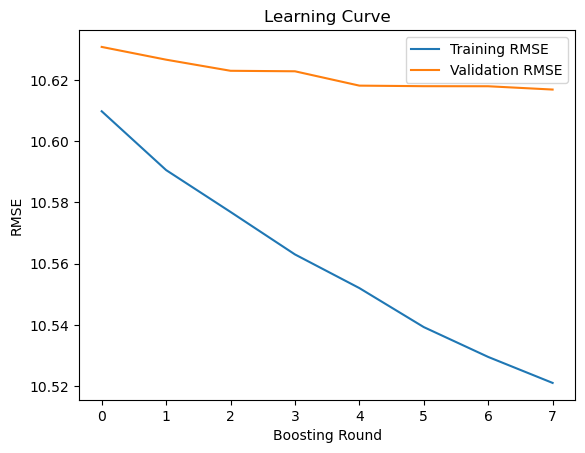

In [179]:
train_rmse = cv_results['train-rmse-mean']
test_rmse = cv_results['test-rmse-mean']

plt.plot(train_rmse, label='Training RMSE')
plt.plot(test_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curve')
plt.show()


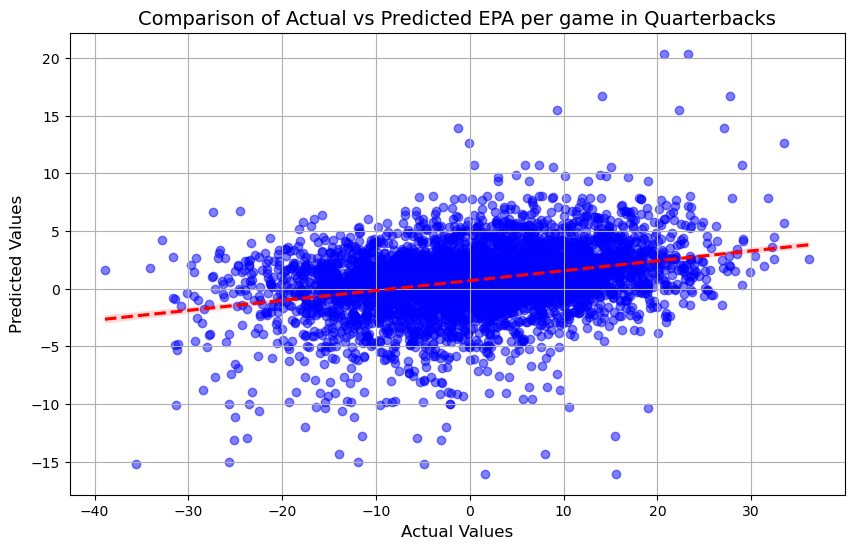

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sum_epa and predicted_values are available as arrays or pandas Series
# For example:
# sum_epa = df['sum_epa']
# predicted_values = model.predict(X_test)

plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity

# Scatterplot with regression line for better comparison
sns.regplot(x=predictions["sum_epa"], y=predictions["predicted_values"], scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red', 'linestyle': '--'})

# Adding labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Comparison of Actual vs Predicted EPA per game in Quarterbacks', fontsize=14)

# Show the plot
plt.grid(True)
plt.show()


### Applications

In our applications section, we are going to try to predict a couple things. First, we will use the residuals to create a weather-adjusted "epa over expected" metric. Then, we will try to see the best players in each circumstance. We will then compare a couple players and explain what the numbers mean.

Here are the best players in terms of weather-adjusted EPA Over Expected

In [180]:
predictions["epaoe"] = predictions["sum_epa"] - predictions["predicted_values"]
predictions["passer_player_name"] = np.where(predictions["passer_player_name"] == "Aa.Rodgers", "A.Rodgers", predictions["passer_player_name"])
# Multiple aggregation functions
# Group by 'passer_player_name' and calculate the mean of 'epaoe'
players = predictions.groupby("passer_player_name").agg(
    mean_epaoe =('epaoe', 'mean'), actual_epa = ("sum_epa", "mean"), count=('passer_player_name', 'size') 

).reset_index()

# Sort by 'mean_epaoe' in descending order
players = players.sort_values(by="mean_epaoe", ascending=False)

# Display the resulting DataFrame
players = players[players["count"] > 10]
print(players)



    passer_player_name  mean_epaoe  actual_epa  count
133          P.Mahomes    8.054402    8.600468    109
164             T.Romo    7.206429    8.898573     14
20             B.Purdy    6.759869    8.199790     27
155            T.Brady    5.472613    6.356368    151
7            A.Rodgers    4.783755    5.816825    125
47             D.Brees    4.173600    5.921350     92
88              J.Love    3.733722    3.831021     18
81         J.Garoppolo    3.693906    4.653359     63
56          D.Prescott    3.162725    3.476615     69
21    B.Roethlisberger    3.146628    4.238270    112
135           P.Rivers    3.123842    4.377399    107
167       T.Tagovailoa    2.975553    3.434438     51
70             J.Allen    2.905284    3.289250     93
41            C.Stroud    2.689166    3.678997     17
3               A.Luck    2.682509    3.808017     55
36            C.Palmer    2.590477    4.459265     19
123         M.Stafford    2.574130    3.815424     83
73            J.Burrow    2.

### Best players in rain:

In [181]:
rainy_games = predictions[predictions["is_rainy"] == 1]
players_rain = rainy_games.groupby("passer_player_name").agg(
    epaoe_rain =('epaoe', 'mean'), epa_rain = ("sum_epa", "mean"), count_rain =('passer_player_name', 'size') 

).reset_index()

players_rain = players_rain.sort_values(by="epaoe_rain", ascending=False)

players_rain = players_rain[players_rain["count_rain"] > 4]
print(players_rain)

   passer_player_name  epaoe_rain   epa_rain  count_rain
24            D.Brees   11.055251  13.282163           5
83            T.Brady    7.418390   6.041208          12
78        R.Tannehill    4.755206   2.791818           5
29         D.Prescott    3.058683  -0.761609           5
12   B.Roethlisberger    2.967816   0.621943           8
2           A.Rodgers    2.220145   2.288956           8
79           R.Wilson    2.208732  -0.059037          12
36            J.Allen    1.774648  -0.540475          12
19           C.Newton    1.390352   1.208961           6
3             A.Smith    1.128869   1.614912           7
57          L.Jackson    0.641758  -1.797334          10
23            C.Wentz    0.164145  -2.199650          10
25             D.Carr   -0.066121  -0.672239           5
0            A.Dalton   -0.327387   0.917141           6
35            G.Smith   -1.163242  -1.692552           5
17           C.Keenum   -1.286403  -4.422141           5
33          E.Manning   -1.4736

### Best players in wind:

In [182]:
windy_games = predictions[predictions["mean_wind"] >14]
players_wind = windy_games.groupby("passer_player_name").agg(
    epaoe_wind =('epaoe', 'mean'), epa_wind = ("sum_epa", "mean"), count_wind =('passer_player_name', 'size') 

).reset_index()

players_wind = players_wind.sort_values(by="epaoe_wind", ascending=False)

players_wind = players_wind[players_wind["count_wind"] > 4]
print(players_wind)

    passer_player_name  epaoe_wind   epa_wind  count_wind
88           P.Mahomes   10.328201   8.877411          15
31             D.Brees    9.557712  14.395182          10
56              J.Goff    6.855964   5.984429           7
100            T.Brady    6.477791   7.018212          13
109       T.Tagovailoa    6.349900   3.194122           7
49            J.Burrow    5.721422   4.772493           6
72           L.Jackson    5.297998   4.003143           7
92       R.Fitzpatrick    4.553936   2.606496          13
2               A.Luck    3.650284   4.480347           5
47             J.Allen    3.581002   2.132090          15
4            A.Rodgers    3.157206   4.210443          13
90            P.Rivers    3.017158   2.258314           9
15    B.Roethlisberger    2.981478   2.535142          13
65           J.Winston    2.956028   2.669636           9
68           K.Cousins    2.499831   3.210447          12
38          D.Prescott    1.843250  -0.620970           5
28            

### Best players in cold

In [183]:
cold_games = predictions[predictions["mean_temp"] >= 32]
players_cold = cold_games.groupby("passer_player_name").agg(
    epaoe_cold =('epaoe', 'mean'), epa_cold = ("sum_epa", "mean"), count_cold =('passer_player_name', 'size') 

).reset_index()

players_cold = players_cold.sort_values(by="epaoe_cold", ascending=False)

players_cold = players_cold[players_cold["count_cold"] > 4]
print(players_cold)

    passer_player_name  epaoe_cold   epa_cold  count_cold
130          P.Mahomes    7.975887   8.794204          95
161             T.Romo    7.874405   9.295938          13
19             B.Purdy    6.759869   8.199790          27
152            T.Brady    5.273582   6.174415         138
7            A.Rodgers    4.479030   5.602281         105
46             D.Brees    4.173600   5.921350          92
80         J.Garoppolo    3.761171   4.849505          62
20    B.Roethlisberger    3.277226   4.484264         105
132           P.Rivers    3.264058   4.441026         105
164       T.Tagovailoa    3.133378   3.899319          49
71          J.Browning    3.125417   3.074888           8
69             J.Allen    2.989958   3.346123          82
40            C.Stroud    2.983196   4.178585          16
55          D.Prescott    2.722463   2.959667          66
3               A.Luck    2.635459   3.748270          53
35            C.Palmer    2.590477   4.459265          19
120         M.

### Final visualizations

In [184]:
players_agg = players.merge(players_rain, on="passer_player_name", how="left") \
                     .merge(players_wind, on="passer_player_name", how="left") \
                     .merge(players_cold, on="passer_player_name", how="left") \
                     .dropna()
players_agg = players_agg.head(10)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


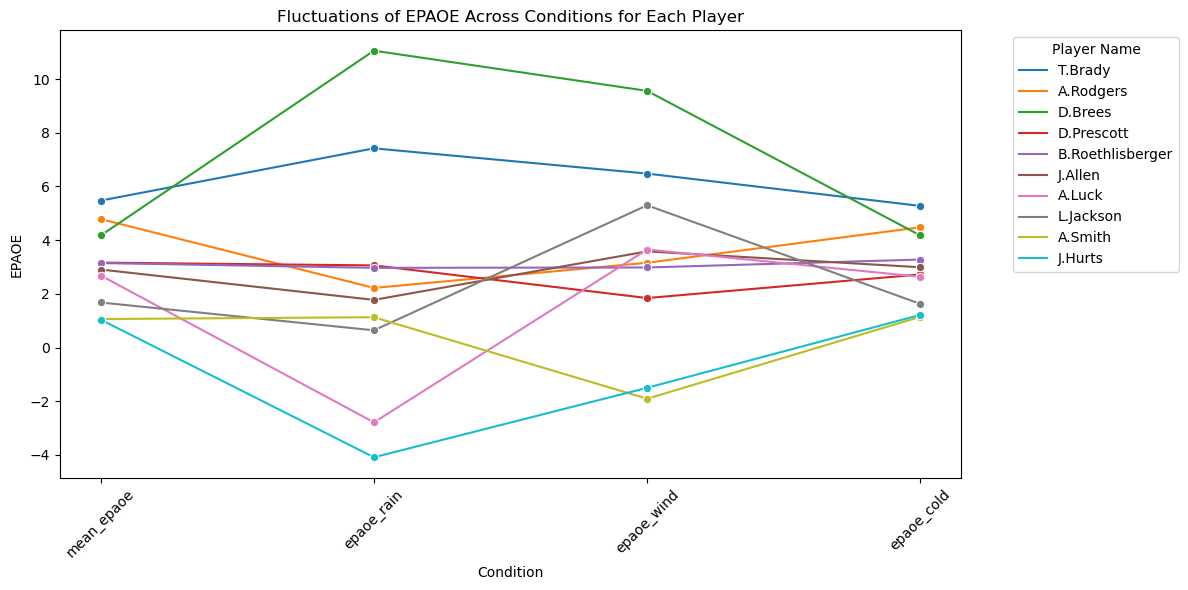

In [185]:
df_melted = players_agg.melt(
    id_vars="passer_player_name", 
    value_vars=["mean_epaoe", "epaoe_rain", "epaoe_wind", "epaoe_cold"],
    var_name="Condition", 
    value_name="EPAOE"
)

# Plot the fluctuations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x="Condition", y="EPAOE", hue="passer_player_name", marker="o")
plt.xticks(rotation=45)
plt.xlabel("Condition")
plt.ylabel("EPAOE")
plt.title("Fluctuations of EPAOE Across Conditions for Each Player")
plt.legend(title="Player Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()